In [30]:
import scipy.stats as ss
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from mave_calibration import main
from joblib import Parallel, delayed
import sys
sys.path.append("/home/dzeiberg")
from mave_results.utils import threshold_utils
from mave_results.utils import skewnorm as skewnorm_utils

In [2]:
true_params = dict(
    fD = ss.skewnorm(a=-2.35217102,
                    loc=-1.55031695,
                    scale=0.77525406),
    fN = ss.skewnorm(a=-0.93037852,
                    loc=0.12707752,
                    scale=0.39826615),
    W = np.array([[0.98189558, 0.01810442],
                [0.03432592, 0.96567408],]),
    prior = 0.12)

In [3]:
from copy import deepcopy
def sample_data(params, sample_sizes, label_noise=0.0):
    fD = params['fD']
    fN = params['fN']
    wPathogenic, wBenign = params['W']
    prior = params['prior']
    nDP, nNP, nDB, nNB = np.round(sample_sizes[-1] * np.array([prior * wPathogenic[0],
                                    prior * wPathogenic[1],
                                    (1-prior) * wBenign[0],
                                    (1-prior) * wBenign[1]])).astype(int)
    cleanPathogenicityLabels = [np.ones(sample_sizes[0],dtype=int),
                                            np.zeros(sample_sizes[1],dtype=int),
                                            np.ones(nDP + nNP,dtype=int),
                                            np.zeros(nDB + nNB,dtype=int)]
    pathogenicityLabels = deepcopy(cleanPathogenicityLabels)
    if label_noise > 0:
        pathogenicityLabels[0] = np.random.binomial(1, 1-label_noise, sample_sizes[0])
        pathogenicityLabels[1] = np.random.binomial(1, label_noise, sample_sizes[1])
    
    sampleNumbers = np.concatenate([1 - pathogenicityLabels[0],
                                    1 - pathogenicityLabels[1],
                                    np.ones(sample_sizes[2],dtype=int)*2])
    pathogenicityLabels = np.concatenate(pathogenicityLabels)
    observations = np.concatenate([
        fD.rvs(np.round(sample_sizes[0] * wPathogenic[0]).astype(int)),
        fN.rvs(np.round(sample_sizes[0] * wPathogenic[1]).astype(int)),
        fD.rvs(np.round(sample_sizes[1] * wBenign[0]).astype(int)),
        fN.rvs(np.round(sample_sizes[1] * wBenign[1]).astype(int)),
        fD.rvs(nDP), fN.rvs(nNP), fD.rvs(nDB), fN.rvs(nNB)])
    sampleIndicators = np.zeros((len(observations), len(sample_sizes)),dtype=int)
    sampleIndicators[np.arange(len(observations)), sampleNumbers] = 1
    return observations, sampleIndicators, pathogenicityLabels, np.concatenate(cleanPathogenicityLabels)


In [6]:
X,S,YTilde, Y = sample_data(true_params, [1000,1000,1000],label_noise=0.1)
rng = np.arange(min(X)-.1,max(X)+.1,0.01)

pStar, bStar, priorsStar,_, _, _,log_lrPlusStar, _ = threshold_utils.get_score_threshold(sorted(X),[dict(component_params=[
    [true_params['fD'].kwds['a'], true_params['fD'].kwds['loc'], true_params['fD'].kwds['scale']],
    [true_params['fN'].kwds['a'], true_params['fN'].kwds['loc'], true_params['fN'].kwds['scale']]],
    weights=np.concatenate((true_params['W'],
                            (true_params['W'][0] * true_params['prior'] + \
                                true_params['W'][1] * (1 - true_params['prior'])).reshape((1,-1))))),],
                                parallel=False)

1it [00:01,  1.78s/it]

apply prior requirement



/home/dzeiberg/miniconda3/envs/mave/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:1634: RuntimeWarning: All-NaN slice encountered
  return fnb._ureduce(a,


In [14]:
from tqdm.autonotebook import trange
def runFitIter(observations, sample_indicators, **kwargs):
    try:
        iter_fit = main.single_fit(observations,sample_indicators,**kwargs)
        return iter_fit, iter_fit['likelihoods'][-1]
    except AssertionError:
        iter_fit = dict(component_params=None, weights=None, likelihoods=[-1 * np.inf])
        return iter_fit, -1 * np.inf

def runFits(observations, sample_indicators,NFITS = 10,
                NBootstraps=100):
    fits = []
    for iteration in trange(NFITS):
        bootstrap_sample_indices = [np.random.choice(np.where(sample_i)[0],
                                                         sample_i.sum(),
                                                         replace=True) for sample_i in sample_indicators.T]
        indices = np.concatenate(bootstrap_sample_indices)
        XB = observations[indices]
        SB = sample_indicators[indices]
        fit_results = Parallel(n_jobs=min(128,NBootstraps),verbose=10)(delayed(runFitIter)(XB,SB) \
                                                                            for i in range(NBootstraps))
        fit_results = sorted(fit_results,key=lambda tup: tup[1],reverse=True)
        fits.append(fit_results[0][0])
    return fits

In [15]:
fits = runFits(X,S)

  0%|          | 0/10 [00:00<?, ?it/s]

[Parallel(n_jobs=100)]: Using backend LokyBackend with 100 concurrent workers.
EM Iteration:   5%|▌         | 540/10000 [00:08<02:37, 60.12it/s, likelihood=-5.303472][Parallel(n_jobs=100)]: Done  88 out of 100 | elapsed:    8.2s remaining:    1.1s
[Parallel(n_jobs=100)]: Done 100 out of 100 | elapsed:   12.7s finished                
[Parallel(n_jobs=100)]: Using backend LokyBackend with 100 concurrent workers.
EM Iteration:   3%|▎         | 338/10000 [00:06<02:13, 72.17it/s, likelihood=-6.109595][Parallel(n_jobs=100)]: Done  88 out of 100 | elapsed:    7.0s remaining:    1.0s
[Parallel(n_jobs=100)]: Done 100 out of 100 | elapsed:   10.5s finished                
[Parallel(n_jobs=100)]: Using backend LokyBackend with 100 concurrent workers.
EM Iteration:   3%|▎         | 328/10000 [00:07<02:55, 55.11it/s, likelihood=-4.828524][Parallel(n_jobs=100)]: Done  88 out of 100 | elapsed:    7.7s remaining:    1.1s
[Parallel(n_jobs=100)]: Done 100 out of 100 | elapsed:   10.0s finished         

In [17]:
Pscores, Bscores, priors,is_inverted, P, B,log_lrPlus, number_invalid_priors = threshold_utils.get_score_threshold(sorted(X), fits,parallel=False)

10it [00:08,  1.16it/s]

apply prior requirement



/home/dzeiberg/miniconda3/envs/mave/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:1634: RuntimeWarning: All-NaN slice encountered
  return fnb._ureduce(a,


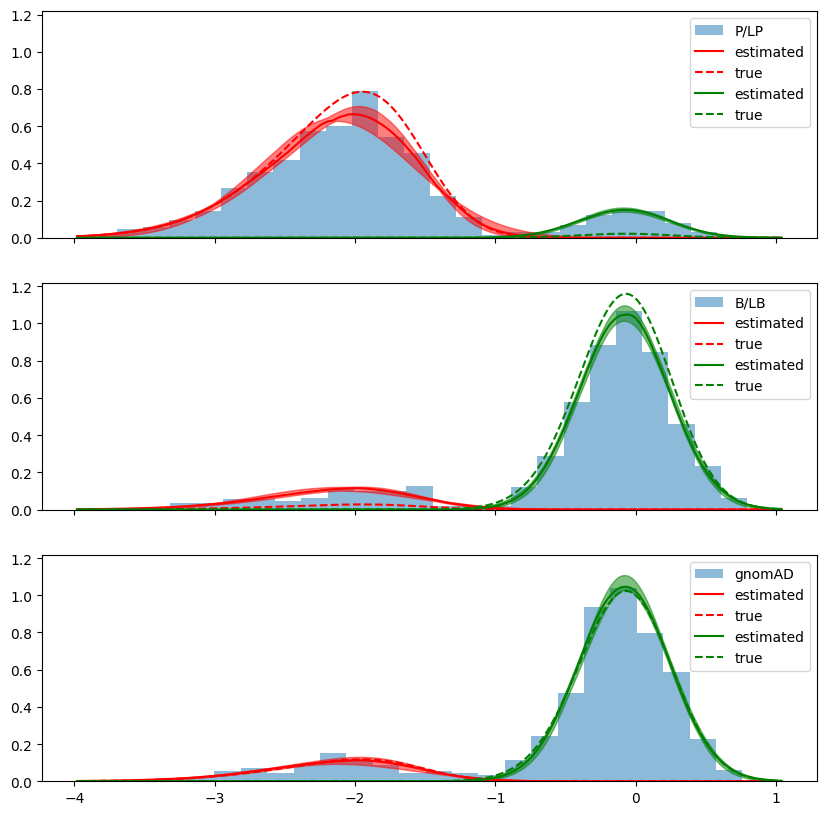

In [55]:
fig,ax = plt.subplots(3,1,figsize=(10,10),sharex=True,sharey=True)
for sampleNum,sampleName in enumerate(["P/LP",'B/LB','gnomAD']):
    ax[sampleNum].hist(X[S[:,sampleNum]==1],
                        bins=25,
                        alpha=0.5,
                        label=sampleName,
                        density=True)
    ax[sampleNum].legend()
W = np.concatenate((true_params['W'],
                            (true_params['W'][0] * true_params['prior'] + \
                                true_params['W'][1] * (1 - true_params['prior'])).reshape((1,-1))))
fD = true_params['fD']
fN = true_params['fN']
prior = true_params['prior']
# ax[0].plot(rng,W[0,0]*fD.pdf(rng) + W[0,1]*fN.pdf(rng),linestyle='--',color='red',label='true')
# ax[1].plot(rng,W[1,0]*fD.pdf(rng) + W[1,1]*fN.pdf(rng),linestyle='--',color='green',label='true')
# ax[2].plot(rng,prior*(W[0,0]*fD.pdf(rng) + W[0,1]*fN.pdf(rng)) + \
#                 (1-prior)*(W[1,0]*fD.pdf(rng) + W[1,1]*fN.pdf(rng)),linestyle='--',color='blue',label='true')

thresholds = {("P","true"):{"+1" : pStar[0],
                            "+2" : pStar[1],
                             "+4" : pStar[3],
                             "+8" : pStar[7],},
                             ("B","true"):{"-1" : bStar[0],
                             "-2" : bStar[1],
                             "-4" : bStar[3],
                             "-8" : bStar[7],}}
for sampleNum in range(3):
    joint_densities = np.stack([skewnorm_utils.joint_densities(rng, fit_i['component_params'], fit_i['weights'][sampleNum]) for fit_i in fits])
    
    ax[sampleNum].plot(rng,np.median(joint_densities[:,0,:],axis=0),linestyle='-',color='red',label='estimated')
    ax[sampleNum].fill_between(rng,*np.percentile(joint_densities[:,0,:],[2.5,97.5],axis=0),alpha=0.5,color='red')
    ax[sampleNum].plot(rng, W[sampleNum,0]*fD.pdf(rng),linestyle='--',color='red',label='true')

    ax[sampleNum].plot(rng,np.median(joint_densities[:,1,:],axis=0),linestyle='-',color='green',label='estimated')
    ax[sampleNum].fill_between(rng,*np.percentile(joint_densities[:,1,:],[2.5,97.5],axis=0),alpha=0.5,color='green')
    ax[sampleNum].plot(rng, W[sampleNum,1]*fN.pdf(rng),linestyle='--',color='green',label='true')

[ax[i].legend() for i in range(3)]
thresholds[("P",'estimated')] = {"+1" : Pscores[0],
                            "+2" : Pscores[1],
                             "+4" : Pscores[3],
                             "+8" : Pscores[7],}
thresholds[('B','estimated')]={"-1" : Bscores[0],
                             "-2" : Bscores[1],
                             "-4" : Bscores[3],
                             "-8" : Bscores[7],}
    

In [56]:
pd.DataFrame.from_dict(thresholds,orient='index').sort_index().round(3).fillna("")

+1     +2     +4 +8     -1     -2     -4 -8
B estimated                         -0.758 -0.726 -0.544   
  true                               -0.93  -0.93 -0.914   
P estimated -1.132 -1.151                                  
  true      -1.072 -1.072 -1.082